In [9]:
from music21 import *
from IPython.display import Image


def music(notes: str, midi: bool = False):
    s = stream.Score()
    part = stream.Part()

    # get info
    info_start = 5

    for i in range(info_start, len(notes)):
        if notes[i : i + 5] == "INFO ":
            info_end = i

    info = list(filter(lambda x: len(x) > 0, notes[info_start:info_end].split(" ")))

    # set clef
    if info[0].lower() == "treble":
        s.append(instrument.AcousticGuitar())
        part.append(clef.TrebleClef())
    elif info[0].lower() == "bass":
        part.append(clef.BassClef())
    elif info[0].lower() == "guitar":
        part.append(clef.TabClef())

    # set key
    keys = [
        ["cb", -7],
        ["gb", -6],
        ["db", -5],
        ["ab", -4],
        ["eb", -3],
        ["bb", -2],
        ["f", -1],
        ["c", 0],
        ["g", 1],
        ["d", 2],
        ["a", 3],
        ["e", 4],
        ["b", 5],
        ["f#", 6],
        ["c#", 7],
    ]
    for k in keys:
        if info[1].lower() == k[0]:
            part.append(key.KeySignature(k[1]))

    # set time signature
    part.append(meter.TimeSignature(info[2]))

    # add notes
    notes = notes[info_end + 5 :].split(" ")
    add_notes = []
    for n in notes:
        # add chord name
        if n[0] == "!":
            add_notes.append(harmony.ChordSymbol(n[1:]))
        # start next measure on a new line
        elif n == "^":
            add_notes.append(layout.SystemLayout(isNew=True))
        else:
            # set variables
            is_chord, is_tie, is_col, lyric = False, "none", "", ""
            # if the note is a chord
            if "(" in n:
                is_chord = True
                note_name = n.replace("(", "").replace(")", "").split(",")
                if "t" in note_name[-1]:
                    note_length = note_name[-1][-2:]
                    note_name[-1] = note_name[-1][:-2]
                else:
                    note_length = note_name[-1][-1]
                    note_name[-1] = note_name[-1][:-1]
            else:
                if "{" in n:
                    is_tie = "start"
                if "}" in n:
                    is_tie = "stop"
                if "[" in n:
                    for i in range(len(n)):
                        if n[i] == "[":
                            lyric_start = i + 1
                        if n[i] == "]":
                            lyric_end = i
                    lyric = n[lyric_start:lyric_end]
                    n = n[:lyric_start - 1]
                if n[-1] == "t":
                    if n[0] == "B":
                        is_col = "#06538a"
                        note_name = n[1:-2].replace("{", "").replace("}", "")
                    elif n[0] == "R":
                        is_col = "#8a062d"
                        note_name = n[1:-2].replace("{", "").replace("}", "")
                    else:
                        note_name = n[:-2].replace("{", "").replace("}", "")
                    note_length = n[-2:]
                else:
                    if n[0] == "B":
                        is_col = "#06538a"
                        note_name = n[1:-1].replace("{", "").replace("}", "")
                    elif n[0] == "R":
                        is_col = "#8a062d"
                        note_name = n[1:-1].replace("{", "").replace("}", "")
                    else:
                        note_name = n[:-1].replace("{", "").replace("}", "")
                    note_length = n[-1:]
            lengths = [["w", 4], ["h", 2], ["d", 3], ["q", 1], ["u", 1.5], ["e", 0.5], ["s", 0.25]]
            for l in lengths:
                if isinstance(note_length, str):
                    if l[0] in note_length:
                        if "t" in note_length:
                            note_length = l[1] * 0.333333333
                        else:
                            note_length = l[1]
            if is_tie == "none":
                if is_col == "":
                    if lyric != "":
                        add_notes.append([note_name, note_length, lyric])
                    else:
                        add_notes.append([note_name, note_length])
                else:
                    if lyric != "":
                        add_notes.append([note_name, note_length, lyric])
                    else:
                        add_notes.append([note_name, note_length, is_col])
            else:
                if is_col == "":
                    if lyric != "":
                        add_notes.append([note_name, note_length, is_tie, lyric])
                    else:
                        add_notes.append([note_name, note_length, is_tie])
                else:
                    if lyric != "":
                        add_notes.append([note_name, note_length, is_tie, is_col, lyric])
                    else:
                        add_notes.append([note_name, note_length, is_tie, is_col])

    for n in add_notes:
        if isinstance(n, list):
            if isinstance(n[0], list):
                add_n = chord.Chord(n[0], quarterLength=n[1])
            else:
                if n[0].lower() == "r":
                    add_n = note.Rest(quarterLength=n[1])
                elif n[0] in ["slash", "s"]:
                    add_n = note.Unpitched()
                    add_n.notehead = "slash"
                    add_n.stemDirection = "noStem"
                    add_n.volume.velocity = 0
                else:
                    add_n = note.Note(n[0], quarterLength=n[1])
            if len(n) == 3:
                if n[2] in ["start", "stop"]:
                    add_n.tie = tie.Tie(n[2])
                elif n[2] not in ["#06538a", "#8a062d"]:
                    texp = expressions.TextExpression(n[2])
                    texp.style.fontsize = 10
                    texp.style.fontFamily = "Segoe UI"
                    texp.placement = "below"
                    part.append(texp)
                else:
                    add_n.style.color = n[2]
            if len(n) == 4:
                add_n.tie = tie.Tie(n[2])
                if n[3] not in ["#06538a", "#8a062d"]:
                    texp = expressions.TextExpression(n[3])
                    texp.style.fontSize = 10
                    texp.style.fontFamily = "Segoe UI"
                    texp.placement = "below"
                    part.append(texp)
                else:
                    add_n.style.color = n[3]
            part.append(add_n)
        else:
            part.append(n)

    if info[0].lower() == "guitar":
        part.makeNotation()

    s.append(part)

    if info[0].lower() == "guitar":
        s.makeNotation()

    swung_part = stream.Part()

    if midi:
        step = 0.0
        for item in part:
            if isinstance(item, note.Note) or isinstance(item, note.Rest):
                if str(step)[-1] == "9":
                    step = float(round(step))
                elif str(step)[-1] == "2":
                    step = float(round(step))
                if isinstance(item, note.Note):
                    new_note = note.Note(item.pitch)
                    if item.tie:
                        if "start" in str(item.tie):
                            new_note.tie = tie.Tie("start")
                        if "stop" in str(item.tie):
                            new_note.tie = tie.Tie("stop")
                        if "continue" in str(item.tie):
                            new_note.tie = tie.Tie("continue")
                else:
                    new_note = note.Rest()
                if str(step)[-2:] == ".0":
                    if item.quarterLength == 0.5:
                        new_note.quarterLength = 0.333333333 * 2
                    elif item.quarterLength == 1.5:
                        new_note.quarterLength = 1 + (0.333333333 * 2)
                    elif str(item.quarterLength) == "1/3":
                        new_note.quarterLength = 0.333333333
                    else:
                        new_note.quarterLength = item.quarterLength
                elif str(step)[-2:] == ".5":
                    if item.quarterLength == 0.5:
                        new_note.quarterLength = 0.333333333
                    elif item.quarterLength == 1.5:
                        new_note.quarterLength = 1 + 0.333333333
                    else:
                        new_note.quarterLength = item.quarterLength
                if str(item.quarterLength) == "1/3":
                    new_note.quarterLength = 0.333333333
                swung_part.append(new_note)
                step += item.quarterLength
            else:
                swung_part.append(item)
        swung_s = stream.Stream()
        guitar = instrument.Guitar()
        swung_s.append(guitar)
        swung_s.append(swung_part)
        return swung_s.show("midi")
    else:
        return Image(filename=s.write("musicxml.png"))

# Music Theory for Guitar Players

by **Chris Wright**

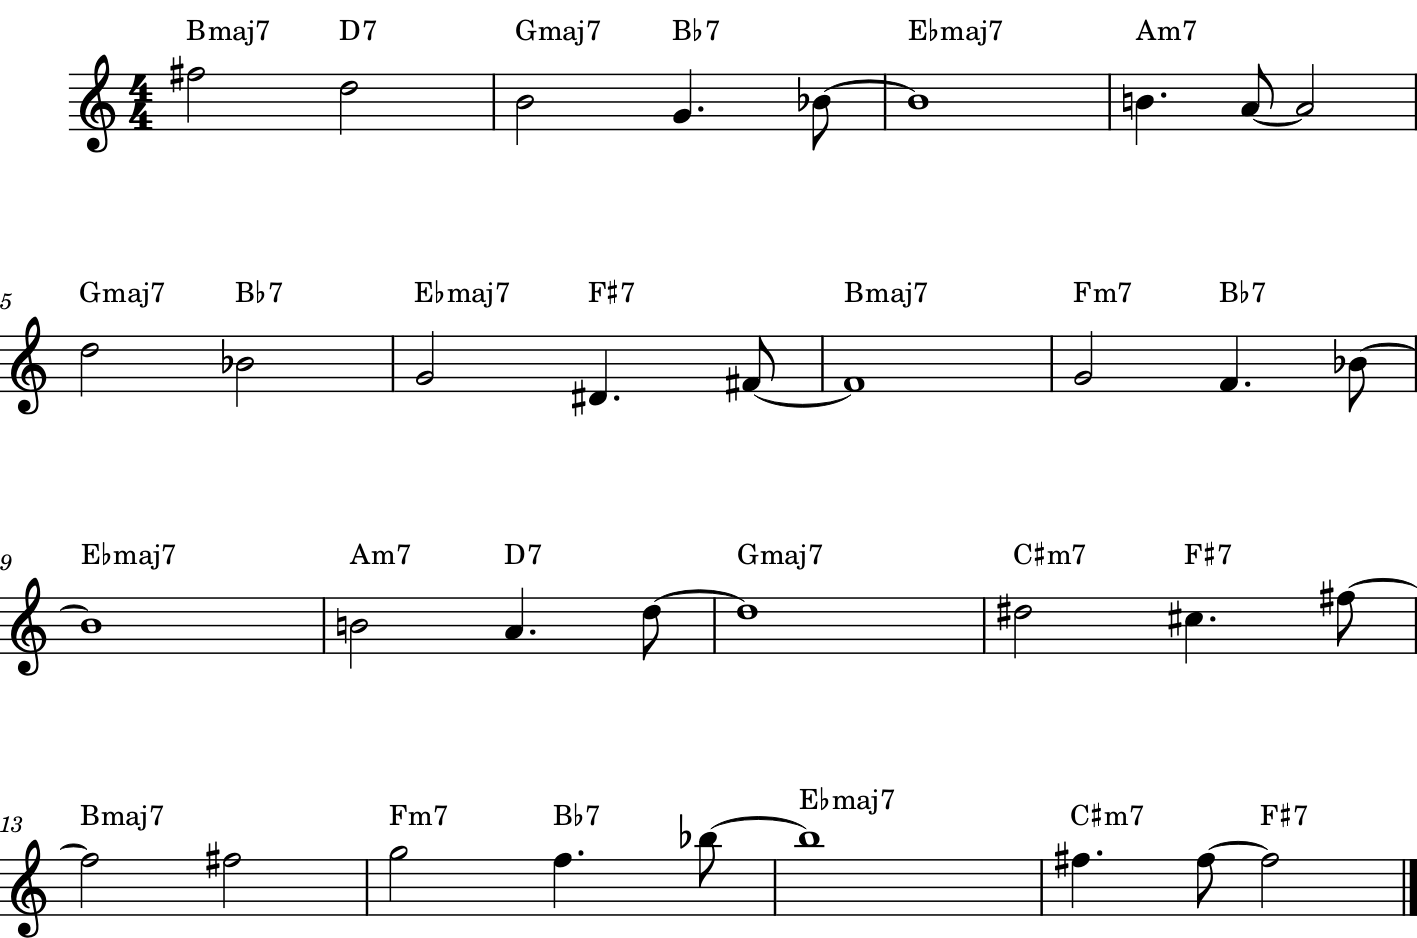

In [3]:
notes = "INFO treble c 4/4 INFO !bmaj7 f#5h !d7 d5h !gmaj7 b4h !b-7 g4u b-4{e !e-maj7 b-4}w !am7 b4u a4{e a4}h ^ "
notes += "!gmaj7 d5h !b-7 b-4h !e-maj7 g4h !f#7 d#4u f#4{e !bmaj7 f#4}w !fm7 g4h !b-7 f4u b-4{e ^ "
notes += "!e-maj7 b-4}w !am7 b4h !d7 a4u d5{e !gmaj7 d5}w !c#m7 d#5h !f#7 c#5u f#5{e ^ "
notes += "!bmaj7 f#5}h f#5h !fm7 g5h !b-7 f5u b-5{e !e-maj7 b-5}w !c#m7 f#5u f#5{e !f#7 f#5}h"
music(notes, True)
music(notes)

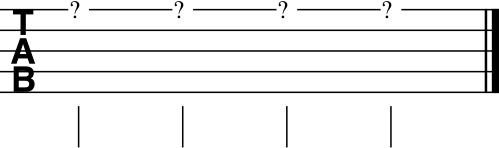

In [10]:
notes = "INFO guitar c 4/4 INFO c4q e4q g4q b4q"
music(notes, True)
music(notes)

This book will be constructed over 4 parts:

1. **Where Are Guitar Notes In Sheet Music?** First we'll break down the names of guitar notes, then we'll see where each note is on a sheet of music.
2. **How Are Chords Constructed?** Here, you'll learn what makes up a chord, how you can voice your chords, and you'll learn about the different symbols on music sheets that specify what chord to play.
3. **How Do Scales Work?** I'm sure you know that minor and major scales sound different, but why is that and how do the minor and major scales relate? You'll also learn about two other minor scales (which can have a nice sound) and you'll be briefed on what modes are (even though, if you're not too deep into music theory, they're not wildly important).
4. **What Are Keys And Time Signatures?** In this section, we'll go over keys in music (and how they're easy to transpose to different keys) and time signatures (with some example songs in their signature).

Hopefully, by the end of this book, you'll be able to pick up a lead sheet for a song and play it easily.

Let's get started!

## Where Are Guitar Notes In Sheet Music?

First things first. Let's find out what notes you're playing when you play your guitar.

## How Are Chords Constructed?

## How Do Scales Work?

## What Are Keys And Time Signatures?